<a href="https://colab.research.google.com/github/dmamur/elementsem/blob/main/notebooks/elembert_classification_siderV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    position_embeddings = layers.Embedding(input_dim=config.MAX_LEN,output_dim=config.EMBED_DIM,
                                           weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
                                           name="position_embedding",)(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model


In [2]:
!pip install ase
!git clone https://github.com/dmamur/elementsem.git
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00
Cloning into 'elementsem'...
remote: Enumerating objects: 579, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 579 (delta 74), reused 1 (delta 1), pack-reused 444
Receiving objects: 100% (579/579), 94.33 MiB | 19.59 MiB/s, done.
Resolving deltas: 100% (290/290), done.
Updating files: 100% (267/267), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 13.4 MB/s eta 0:00:00


In [3]:
class Config:
    MAX_LEN = 1024
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembertR_'
    MVER = 'V0'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=2344567
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
! wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/sider.csv.gz

--2023-09-05 21:49:40--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/sider.csv.gz
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.193.178, 52.219.193.154, 52.219.121.42, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.193.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34759 (34K) [application/x-gzip]
Saving to: ‘sider.csv.gz’

sider.csv.gz        100%[===================>]  33.94K  --.-KB/s    in 0.02s   

2023-09-05 21:49:41 (1.45 MB/s) - ‘sider.csv.gz’ saved [34759/34759]



In [16]:
dsN=1 # set SIDER column: from 1 to 27
ds = 'sider_%s' %  dsN
mname=config.PATH+config.MNAME+ds+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)

# Load vocabulary and types

In [17]:
from rdkit import Chem
import gzip
with gzip.open('sider.csv.gz', 'rb') as file:
    df = pd.read_csv(file)
#print(df.head())
types,labels=[],[]
for i,j in zip(df['smiles'],df.iloc[:,dsN].to_numpy()):
  try:
    m = Chem.MolFromSmiles(i)
    m = Chem.AddHs(m)
    types.append([atom.GetSymbol() for atom in m.GetAtoms()])
    labels.append(j)
  except:
    pass
labels  = to_categorical(np.asarray(labels))
uniquelbls=len(np.unique(np.asarray(df.iloc[:,dsN])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


[21:59:06] WARNING: not removing hydrogen atom without neighbors
[21:59:06] WARNING: not removing hydrogen atom without neighbors
[21:59:06] WARNING: not removing hydrogen atom without neighbors
[21:59:06] WARNING: not removing hydrogen atom without neighbors
[21:59:06] WARNING: not removing hydrogen atom without neighbors
[21:59:06] WARNING: not removing hydrogen atom without neighbors
[21:59:06] WARNING: not removing hydrogen atom without neighbors
[21:59:06] WARNING: not removing hydrogen atom without neighbors
[21:59:07] WARNING: not removing hydrogen atom without neighbors
[21:59:07] WARNING: not removing hydrogen atom without neighbors
[21:59:07] WARNING: not removing hydrogen atom without neighbors
[21:59:07] WARNING: not removing hydrogen atom without neighbors
[21:59:07] WARNING: not removing hydrogen atom without neighbors


vocabSize:  101


In [18]:
df.iloc[:,dsN].to_numpy()

array([1, 0, 0, ..., 1, 0, 1])

In [19]:
print('dataLen: ', len(types), '   OriginalDataLen: ', len(df['smiles']))

dataLen:  1427    OriginalDataLen:  1427


In [20]:
np.max([len(i) for i in types])

940

# Convert types to integers

In [21]:
from collections import defaultdict
element2id = defaultdict(lambda: 1, element2id)
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#z = load_model(config.PREPATH+'/embert'+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z = load_model(config.PREPATH+'/elEmBERT'+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z.trainable = True

inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')
z = create_elembert_model(inputC,config)

e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax",name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

#plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

model.summary()

csv_logger = tf.keras.callbacks.CSVLogger(mname+"_log.csv", append=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(mname+".h5",verbose=2, mode='min',save_freq=20000,)

callbacks_list = [checkpoint,csv_logger]

print('dataLen: ',x3.shape,labels.shape)



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 types (InputLayer)             [(None, 1024)]       0           []                               
                                                                                                  
 element_embdgs (Embedding)     (None, 1024, 32)     3232        ['types[0][0]']                  
                                                                                                  
 tf.__operators__.add_5 (TFOpLa  (None, 1024, 32)    0           ['element_embdgs[0][0]']         
 mbda)                                                                                            
                                                                                                  
 encoder_0/multiheadattention (  (None, 1024, 32)    4224        ['tf.__operators__.add_5[0]

In [22]:
epochs=config.BATCH_SIZE*4

p = np.random.RandomState(seed=seed).permutation(len(labels))
n = len(p)

trainidx=p[:round(len(p)*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

trainlog = model.fit(x=x3[trainidx], y=labels[trainidx],
                     validation_data = (x3[validx],labels[validx]),
                     verbose = 1,epochs = epochs, batch_size = config.BATCH_SIZE,callbacks = callbacks_list)

model.save(mname+".h5")

Epoch 1/128
36/36 [==============================] - 13s 123ms/step - loss: 0.7429 - auc_2: 0.5236 - val_loss: 0.6907 - val_auc_2: 0.5464
Epoch 2/128
36/36 [==============================] - 3s 78ms/step - loss: 0.7041 - auc_2: 0.5096 - val_loss: 0.6914 - val_auc_2: 0.5409
Epoch 3/128
36/36 [==============================] - 3s 78ms/step - loss: 0.6992 - auc_2: 0.5300 - val_loss: 0.6904 - val_auc_2: 0.5408
Epoch 4/128
36/36 [==============================] - 3s 78ms/step - loss: 0.7022 - auc_2: 0.5043 - val_loss: 0.6903 - val_auc_2: 0.5464
Epoch 5/128
36/36 [==============================] - 3s 79ms/step - loss: 0.7066 - auc_2: 0.4892 - val_loss: 0.6960 - val_auc_2: 0.4602
Epoch 6/128
36/36 [==============================] - 3s 80ms/step - loss: 0.7052 - auc_2: 0.5050 - val_loss: 0.6922 - val_auc_2: 0.5371
Epoch 7/128
36/36 [==============================] - 3s 81ms/step - loss: 0.7048 - auc_2: 0.5002 - val_loss: 0.6905 - val_auc_2: 0.5371
Epoch 8/128
36/36 [===========================

# Save results

In [23]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['smiles']
dbresults['ids'] = df.iloc[:,0]
dbresults['types'] = types
dbresults['trainidx'] = trainidx
dbresults['testidx'] = testidx
dbresults['validx'] = validx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

45/45 [==============================] - 2s 32ms/step


# Postprocessing

In [24]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [25]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1))
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1))
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]

binary tf-acc: 0.57342654
/content/elementsem/models/elembertR_sider_1_V0_E_32_H_2_L_2_bert.h5  AUC: 0.596704


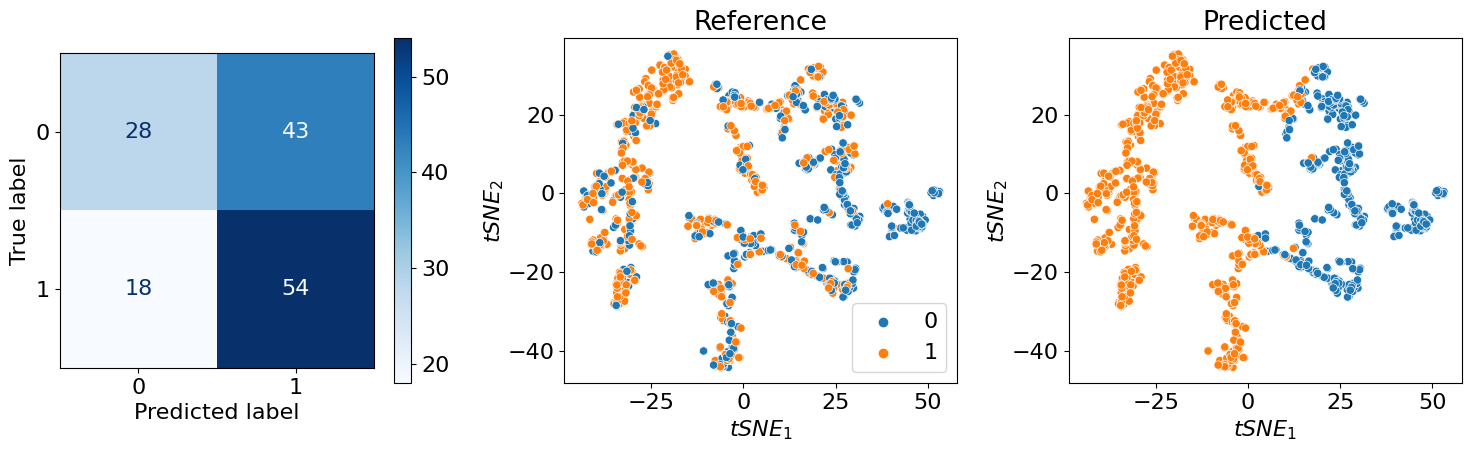

<Figure size 640x480 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'][dbresults['testidx']].argmax(axis=-1)
y_classes = dbresults['y_cls'][dbresults['testidx']].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'][dbresults['testidx']], dbresults['pred_cls'][dbresults['testidx']])
print(mname, ' AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")